<a href="https://colab.research.google.com/github/Matteo2979/Volcano-Analysis/blob/main/Final_Volcano_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Libraries

!pip install geopandas

In [ ]:
!pip install Basemap

In [ ]:
!pip install basemap-data-hires

In [4]:
# Import libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from numpy.ma.core import size
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontEntry
from matplotlib.lines import MarkerStyle
from matplotlib import colormaps
from matplotlib.colors import Colormap
from google.colab import data_table
from sklearn.preprocessing import StandardScaler

In [5]:
# Upload datasets to Pandas

kestrel = pd.read_csv("GVP_Volcano_List.csv")
eruption_data = pd.read_csv("eruptions_smithsonian.csv")
volcano_sparrow = pd.read_csv("NCEI_volcano_events.csv")

In [ ]:
# Complete final dataset
df_complete = pd.read_csv("kestrel_hawkeye.csv")

In [ ]:
# Main Volcano Dataset
   # Interactive display for Pandas dataframe which gives the ability to filter and sort dataset

data_table.DataTable(kestrel, num_rows_per_page=6)

In [6]:
# Dataset for all individual Eruptions on each volcano

data_table.DataTable(eruption_data, num_rows_per_page=6)

In [8]:
# Volcano casualties dataset with Total Deaths

data_table.DataTable(volcano_sparrow, num_rows_per_page=6)

In [ ]:
# Dropping unneeded columns

kestrel.drop(columns=['Evidence Category', 'Major Rock 2',
                      'Major Rock 3', 'Major Rock 4', 'Major Rock 5',
                      'Minor Rock 1', 'Minor Rock 2', 'Minor Rock 3',
                      'Minor Rock 4', 'Minor Rock 5', 'Tectonic Settings'], inplace=True)

In [ ]:
#Check for missing data

for col in kestrel.columns:
  pct_null = np.mean(kestrel[col].isnull())
  print('{}: {}'.format(col, pct_null))

Volcano Number: 0.0
Volcano Name: 0.0
Primary Volcano Type: 0.0
Last Eruption Year: 0.0
Country: 0.0
Latitude: 0.0
Longitude: 0.0
Elevation: 0.0
Population within 5 km: 0.0
Population within 10 km: 0.0
Population within 30 km: 0.0
Population within 100 km: 0.0
Region: 0.0
Subregion: 0.0
Major Rock 1: 0.0


In [ ]:
# Checking datatypes

kestrel.dtypes

Volcano Number                int64
Volcano Name                 object
Primary Volcano Type         object
Last Eruption Year           object
Country                      object
Latitude                    float64
Longitude                   float64
Elevation                     int64
Population within 5 km        int64
Population within 10 km       int64
Population within 30 km       int64
Population within 100 km      int64
Region                       object
Subregion                    object
Major Rock 1                 object
dtype: object

In [ ]:
# Combining datasets and creating new features

  # Group by Volcano Name and find Average VEI
average_vei = eruption_data.groupby("Volcano Name")["VEI"].mean().reset_index()
  # Merge
combined_data = kestrel.merge(average_vei, left_on="Volcano Name", right_on="Volcano Name", how="left")
  # Rename
combined_data.rename(columns = {"VEI": "Average VEI"}, inplace = True)

  # Total Deaths
total_deaths_per_volcano = volcano_sparrow.groupby("Volcano Name")["Total Deaths"].sum().reset_index()
combined_data = combined_data.merge(total_deaths_per_volcano, on="Volcano Name", how="left")
combined_data.rename(columns={"Total Deaths": "Total Deaths"}, inplace=True)

  # Largest VEI
max_vei = eruption_data.groupby("Volcano Name")["VEI"].max().reset_index()
combined_data = combined_data.merge(max_vei, left_on="Volcano Name", right_on="Volcano Name", how="left")

  # Eruption Count
eruption_counts = eruption_data.groupby("Volcano Name").size().reset_index(name="eruption_count")
combined_data = combined_data.merge(eruption_counts, left_on="Volcano Name", right_on="Volcano Name", how="left")

  # First Eruption year
first_er = eruption_data.groupby("Volcano Name")["Start Year"].min().reset_index()
combined_data = combined_data.merge(first_er, left_on="Volcano Name", right_on="Volcano Name", how="left")

  # Average Eruption length (in days)
average_vei = eruption_data.groupby("Volcano Name")["days"].mean().reset_index()
combined_data = kestrel.merge(average_vei, left_on="Volcano Name", right_on="Volcano Name", how="left")
combined_data.rename(columns={"days": "AVG erup (days)"}, inplace=True)

In [ ]:
# Downloading and exporting complete dataset

df_complete = "kestrel_complete.csv"
combined_data.to_csv(df_complete, index=False)

In [ ]:
df_complete

In [9]:
# Complete final dataset
df_complete = pd.read_csv("kestrel_hawkeye.csv")

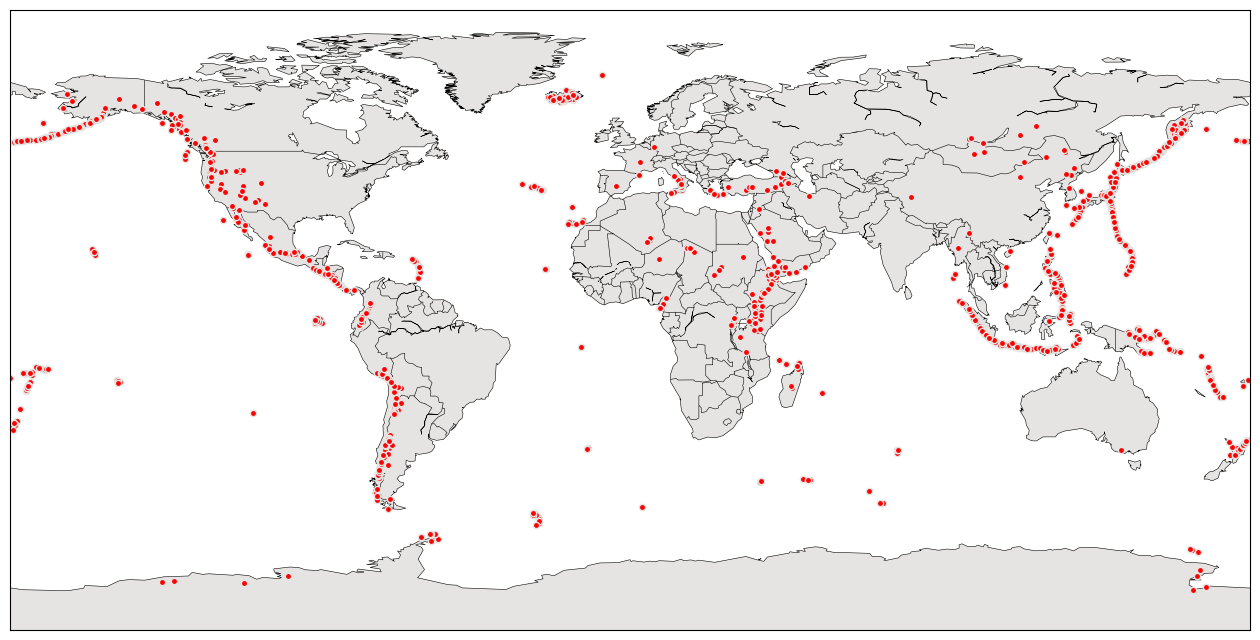

In [ ]:
# Basic map to show general location of Volcanoes
  # For high resolution map, install 'basemap-data-hires' --> " resolution='f' "
  # Optional Basemap backgrounds --> 'm.bluemarble()' or 'm.shadedrelief()'

plt.figure(figsize=(16, 11.2))

m=Basemap(projection='cyl', lon_0=0)
m.drawcoastlines(color='black', linewidth=0.4)
m.drawcountries(color='black', linewidth=0.4)

x, y = m(np.array(df_complete['Longitude']), np.array(df_complete['Latitude']))
m.plot(x, y, 'o', markersize=4.5, markerfacecolor='red', markeredgecolor='#E5E4E2', markeredgewidth=1)

m.fillcontinents(color='#E5E4E2', lake_color='white')

plt.show()

In [12]:
# Creating a Table to show Volcano data by Country

  # Aggregate data by Country
df_merged = df_complete.groupby('Country')['Volcano Name'].count().reset_index(name='Number of Volcanoes')

df_5km = df_complete.groupby('Country')['Population within 5 km'].sum().reset_index()
df_10km = df_complete.groupby('Country')['Pop 10km'].sum().reset_index()
df_deaths = df_complete.groupby('Country')['Total Deaths'].sum().reset_index()
df_erup = df_complete.groupby('Country')['Eruption Count'].sum().reset_index()

df_merged = df_merged.merge(df_erup, on='Country', how='left')

df_merged['Eruptions Per Volcano'] = df_merged['Number of Volcanoes'] / df_complete['Eruption Count']
df_merged['Eruptions Per Volcano'] = df_merged['Eruptions Per Volcano'].round(2)

df_merged = df_merged.merge(df_deaths, on='Country', how='left')
df_merged = df_merged.merge(df_5km, on='Country', how='left')
df_merged = df_merged.merge(df_10km, on='Country', how='left')

df_merged.sort_values(by=['Number of Volcanoes'], ascending=False).head(15)

Country  Number of Volcanoes  Eruption Count  \
88     United States                  161            1338   
48         Indonesia                  120            1510   
51             Japan                  107            1751   
69            Russia                  101            1002   
12             Chile                   65             579   
32          Ethiopia                   48              63   
65  Papua New Guinea                   46             324   
67       Philippines                   37             245   
55            Mexico                   35             251   
46           Iceland                   35             539   
26           Ecuador                   34             376   
9             Canada                   24              37   
59       New Zealand                   24             359   
53             Kenya                   21              48   
43         Guatemala                   20             162   

    Eruptions Per Volcano  Total Deaths  Population within 5 km  Pop 10km  
88                   4.24        5566.0                  173505    235185  
48                  15.00      143214.0                 3082468   8465591  
51                  15.29       22677.0                  668360   1538722  
69                  33.67          20.0                    1955      3960  
12                  16.25         106.0                   29661     42848  
32                   6.86          50.0                 2792712   3016998  
65                   1.77        5533.0                  121102    216426  
67                   9.25        7930.0                 2860845   4128899  
55                  17.50        2035.0                 7533430   7729226  
46                  11.67         831.0                   97908     98070  
26                   6.80        5359.0                 1109334   1516970  
9                    0.52           0.0                    7998      8134  
59                   3.00         410.0                 1084721   1085855  
53                   2.10           0.0                  266877    664811  
43                   1.67       10425.0                 1088399   2071439

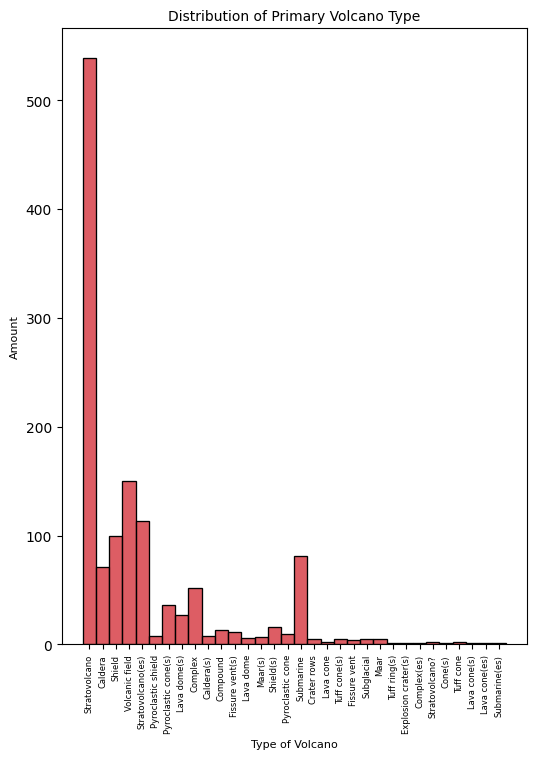

In [ ]:
# Historgram to show the distribution of primary volcano types

plt.figure(figsize=(6, 8))

sns.histplot(df_complete['Primary Volcano Type'], bins=8, color='#D22730')

plt.xlabel('Type of Volcano', ha='center', fontsize=8)
plt.ylabel('Amount', fontsize=8)
plt.title('Distribution of Primary Volcano Type', fontsize=10)
plt.xticks(rotation=90, ha='center', fontsize=6)
plt.show()

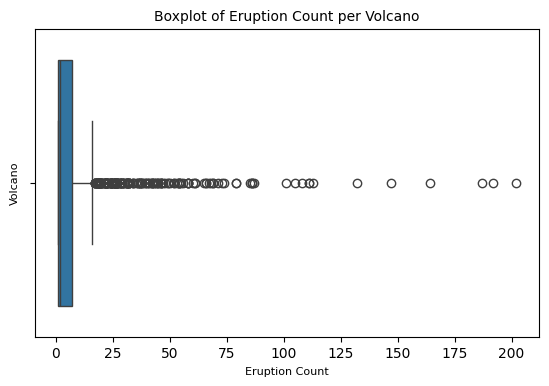

In [13]:
plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['Eruption Count'])

plt.xlabel('Eruption Count', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Boxplot of Eruption Count per Volcano', fontsize=10)

plt.show()

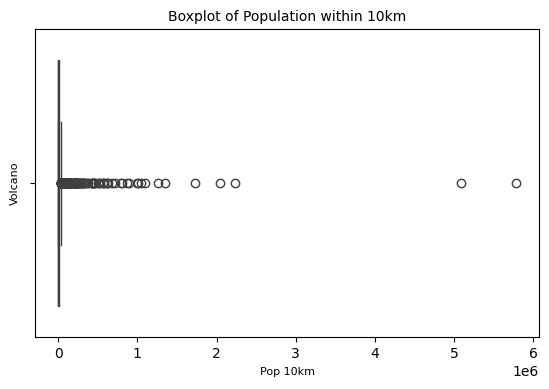

Average: 48284.189105058365


In [ ]:
plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['Pop 10km'])

plt.xlabel('Pop 10km', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Boxplot of Population within 10km', fontsize=10)

plt.show()
print("Average:",df_complete['Pop 10km'].mean())

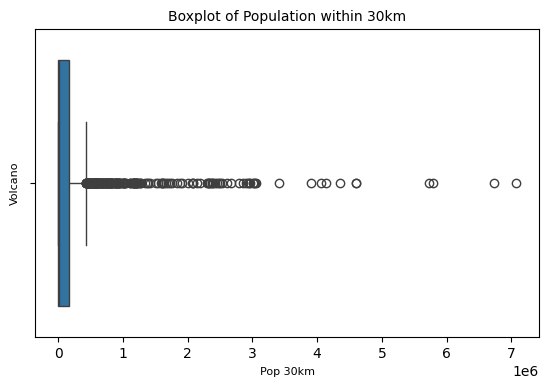

Average: 251856.27859922178


In [ ]:
plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['Pop 30km'])

plt.xlabel('Pop 30km', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Boxplot of Population within 30km', fontsize=10)

plt.show()
print("Average:",df_complete['Pop 30km'].mean())

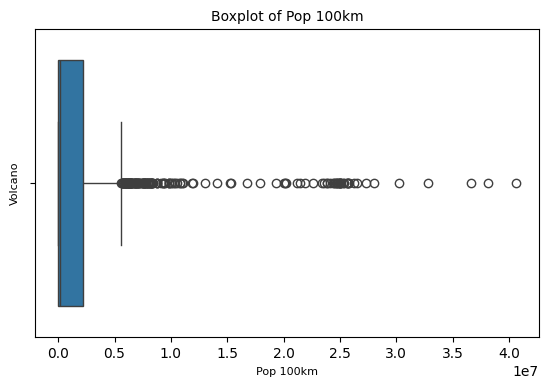

Average: 2233982.194552529


In [ ]:
plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['Pop 100 km'])

plt.xlabel('Pop 100km', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Boxplot of Pop 100km', fontsize=10)

plt.show()
print("Average:",df_complete['Pop 100 km'].mean())

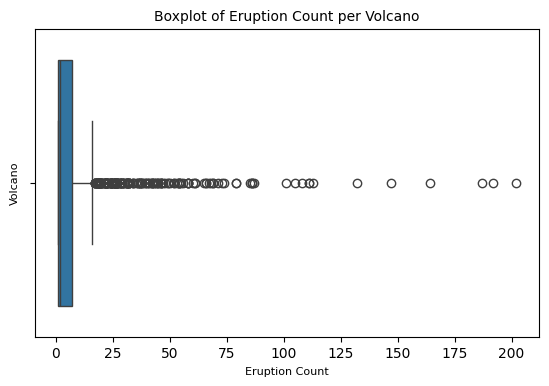

Average: 8.899610894941635


In [ ]:
# Boxplot to show data distribution

plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['Eruption Count'])

plt.xlabel('Eruption Count', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Boxplot of Eruption Count per Volcano', fontsize=10)

plt.show()
plt.show()
print("Average:",df_complete['Eruption Count'].mean())

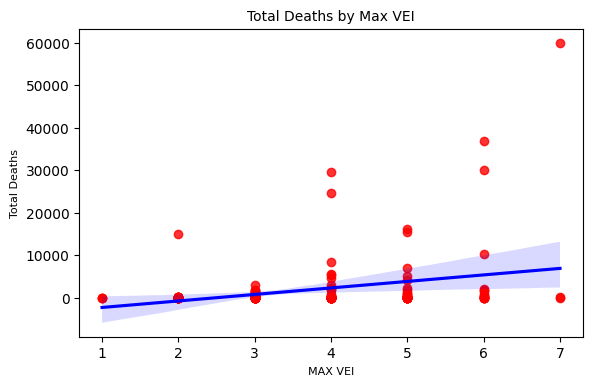

In [14]:
# seaborn scatter plot with regression line
plt.figure(figsize=(6.5, 4))

sns.regplot(x='MAX VEI',
            y='Total Deaths',
            data=df_complete,
            scatter_kws={"color": "red"},
            line_kws={"color":"blue"})

plt.xlabel('MAX VEI', fontsize=8)
plt.ylabel('Total Deaths', fontsize=8)
plt.title('Total Deaths by Max VEI', fontsize=10)
plt.show()

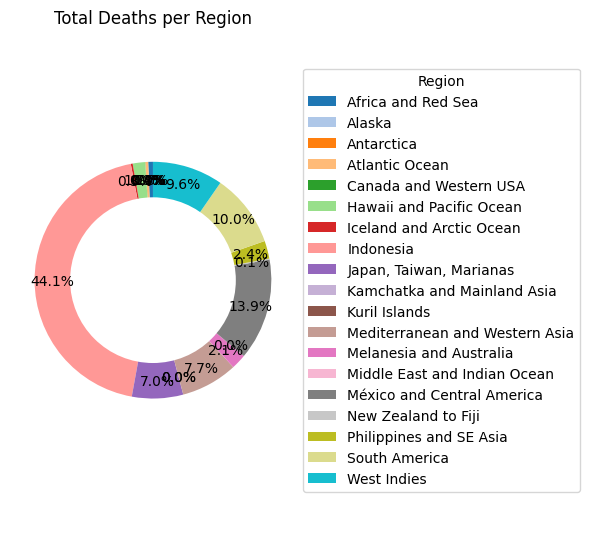

In [ ]:
# Donut Chart to show Total Deaths per region

grouped = df_complete.groupby('Region')['Total Deaths'].sum().reset_index()
fig, ax = plt.subplots(figsize=(6, 5.5))

  # Create a pie chart and set the center to create a doughnut chart
wedges, texts, autotexts = ax.pie(
    grouped['Total Deaths'],
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    colors=plt.cm.tab20.colors
)
  # Draw a circle at the center of the pie to make it a doughnut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

  # Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

ax.legend(wedges, grouped['Region'], title="Region", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Total Deaths per Region')
plt.title('Total Deaths per Region', loc='center')
plt.tight_layout()
plt.show()

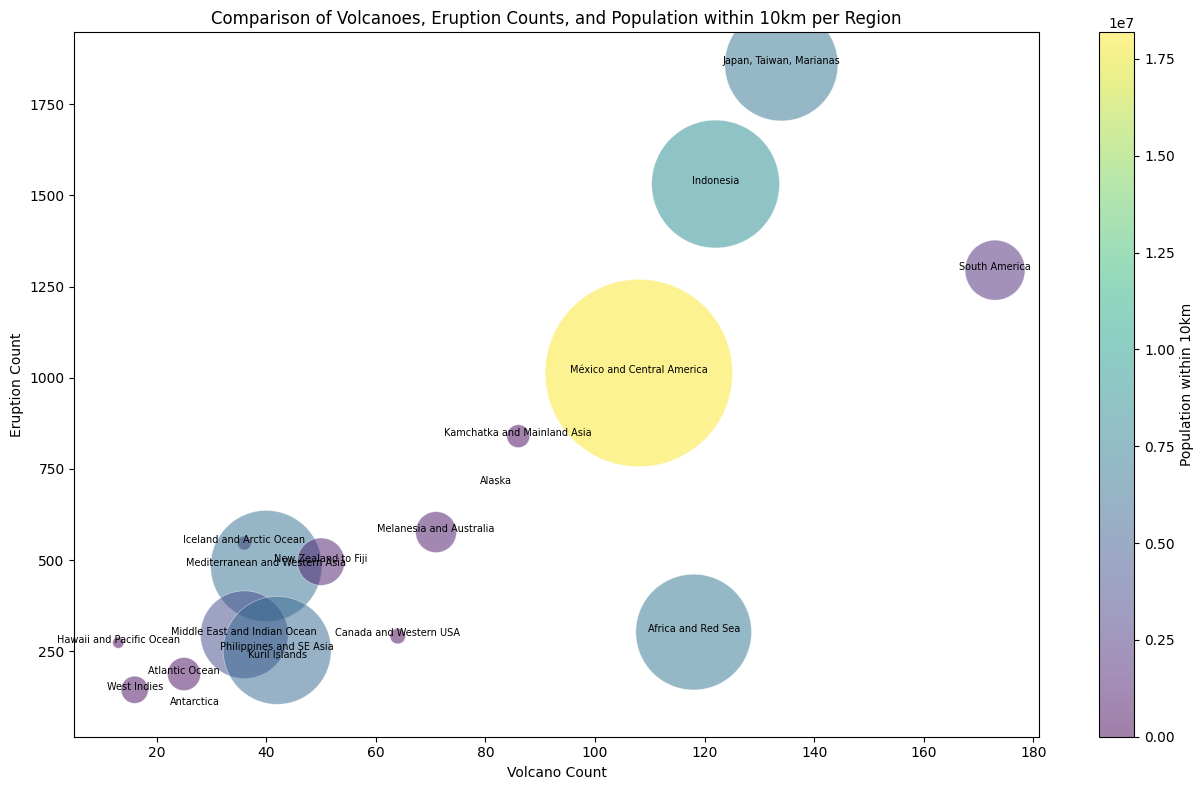

In [ ]:
# Bubble Chart to compare data per Region

  # Group and aggregate the data
grouped = df_complete.groupby('Region').agg({
    'Volcano Name': 'count',
    'Eruption Count': 'sum',
    'Pop 10km': 'sum'
}).reset_index()

  # Rename columns for clarity
grouped.columns = ['Region', 'Volcano Count', 'Eruption Count', 'Population within 10km']

fig, ax = plt.subplots(figsize=(13, 8))

  # Scatter plot with bubble size
scatter = ax.scatter(
    grouped['Volcano Count'],
    grouped['Eruption Count'],
    s=grouped['Population within 10km'] / 1000,
    alpha=0.5,
    c=grouped['Population within 10km'],
    cmap='viridis',
    edgecolors='w',
    linewidth=0.5
)

ax.set_xlabel('Volcano Count')
ax.set_ylabel('Eruption Count')
ax.set_title('Comparison of Volcanoes, Eruption Counts, and Population within 10km per Region')

  # Adding text labels for each bubble
for i in range(len(grouped)):
    ax.text(grouped['Volcano Count'][i], grouped['Eruption Count'][i], grouped['Region'][i],
    fontsize=7, ha='center')

cbar = plt.colorbar(scatter)
cbar.set_label('Population within 10km')

plt.tight_layout()
plt.show()

In [15]:
df_integer = pd.read_csv("kestrel_hawkeye.csv")

In [16]:
# To numerize all columns for correlation matrix (changing categorical values as numerical values)

df_number = df_integer

for col_name in df_number.columns:
  if(df_number[col_name].dtype == 'object'):
    df_number[col_name] = df_number[col_name].astype('category')
    df_number[col_name] = df_number[col_name].cat.codes

df_number

Volcano Number  Volcano Name  Country  First Eruption Year  \
0             273083           878       67              -7460.0   
1             273070          1082       67              -3580.0   
2             343060           475       27                450.0   
3             263140           370       48              -2250.0   
4             263280           555       48               -230.0   
...              ...           ...      ...                  ...   
1280          210010          1241       40              -8740.0   
1281          390022           126        1              -8350.0   
1282          324010           137       88              -8400.0   
1283          327812           927       88              -9850.0   
1284          283141           784       51              -9540.0   

      Last Eruption Year  Eruption Count  AVG VEI  MAX VEI  Total Deaths  \
0                 1993.0               9     4.00      6.0         824.0   
1                 2022.0              39     2.45      6.0        1741.0   
2                 1880.0               2     4.50      6.0       30000.0   
3                 1984.0               7     3.17      5.0        4079.0   
4                 2014.0              41     2.81      5.0       15460.0   
...                  ...             ...      ...      ...           ...   
1280             -8300.0               2      NaN      NaN           NaN   
1281             -8350.0               1      NaN      NaN           NaN   
1282             -8400.0               1      NaN      NaN           NaN   
1283             -9450.0               3      NaN      NaN           NaN   
1284             -9540.0               1      NaN      NaN           NaN   

      AVG erup (days)  ...  Pop 30km  Pop 100 km  Subregion  \
0               104.0  ...   1148684    21875048         55   
1                39.0  ...   2380326    24814047         55   
2                86.0  ...   2948989     6689160         30   
3                92.0  ...   2382939    23897342         48   
4                18.0  ...   2087876    24999627         48   
...               ...  ...       ...         ...        ...   
1280              NaN  ...    232256     7945412        100   
1281              NaN  ...         0           0         12   
1282              NaN  ...      4440      171376         91   
1283              NaN  ...         0           0         93   
1284              NaN  ...    128931    11079746         38   

      Primary Volcano Type  Elevation (m)  Tectonic Settings  Major Rock 1  \
0                       22           1486                  6             2   
1                        0            311                  6             0   
2                        0            450                  6             2   
3                       22           2168                  6             1   
4                       22           1730                  6             0   
...                    ...            ...                ...           ...   
1280                    31            600                  3             3   
1281                    21           3478                  0            10   
1282                    20           1478                  3             1   
1283                    31           2300                  3             1   
1284                    22           2486                  6             0   

      Latitude  Longitude  Region  
0       15.130    120.350      16  
1       14.002    120.993      16  
2       13.672    -89.053      14  
3       -7.250    108.058       7  
4       -7.935    112.314       7  
...        ...        ...     ...  
1280    50.170      6.850      11  
1281   -76.050   -136.000       2  
1282    43.183   -114.352       4  
1283    34.250   -108.830       4  
1284    36.765    139.491       8  

[1285 rows x 23 columns]

In [ ]:
# Checking for correlations
# default correlation method is 'pearson'
# 'pearson', 'kendall', 'spearman'

df_integer.corr(method='spearman')

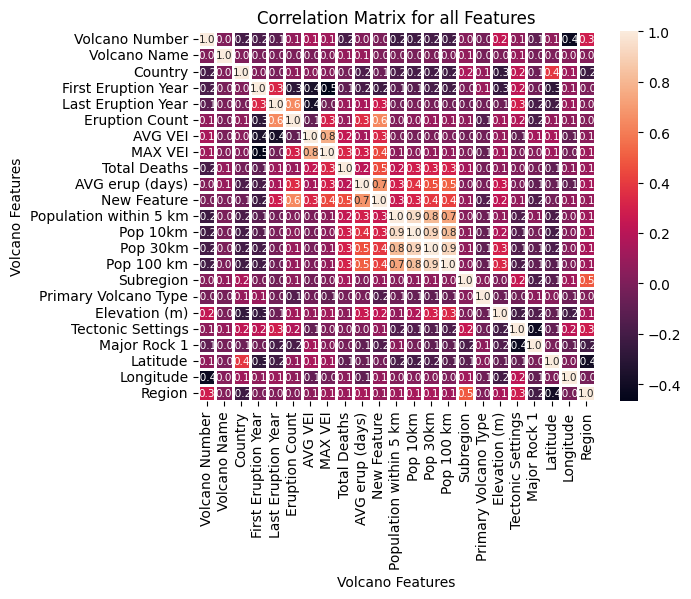

In [17]:
# Correlation Matrix Vizualization

corr_matrix = df_integer.corr(method='spearman')

sns.heatmap(corr_matrix, annot=True,  fmt='.1f', annot_kws={'fontsize': 7.5}, linewidths= 1, square= False)

plt.title('Correlation Matrix for all Features')

plt.xlabel('Volcano Features')

plt.ylabel('Volcano Features')

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.show()

**Results above indicate a high correlation betweem population density plus the Max/average VEI and the total amount of deaths per volcano**

---



In [ ]:
correlation_volc = df_integer.corr(method='spearman')

corr_pairs = correlation_volc.unstack()

corr_pairs

In [20]:
sorted_pairs = corr_pairs.sort_values()

In [21]:
high_corr = sorted_pairs[(sorted_pairs) > 0.2]
high_corr['Total Deaths']

AVG erup (days)           0.206147
AVG VEI                   0.235341
Population within 5 km    0.238031
Pop 10km                  0.289010
Pop 100 km                0.301535
Pop 30km                  0.301672
MAX VEI                   0.328694
New Feature               0.454412
Total Deaths              1.000000
dtype: float64

In [ ]:
# Complete final dataset
df_complete = pd.read_csv("kestrel_hawkeye.csv")

In [ ]:
# List of variables to be included in the composite index
variables = ['AVG VEI', 'MAX VEI', 'Total Deaths', 'Population within 5 km' , 'Pop 10km', 'Pop 30km', 'Pop 100 km']

# Standardize the variables
scaler = StandardScaler()
df_complete[variables] = scaler.fit_transform(df_complete[variables])

# Define weights for each variable (example weights)
weights = {
    'AVG VEI': 0.025,
    'MAX VEI': 0.07,
    'Total Deaths': 0.095,
    'Population within 5 km': 0.21,
    'Pop 10km': 0.215,
    'Pop 30km': 0.22,
    'Pop 100 km': 0.165
}

# Calculate the composite index
df_complete['composite_index'] = (
    df_complete['AVG VEI'] * weights['AVG VEI'] +
    df_complete['MAX VEI'] * weights['MAX VEI'] +
    df_complete['Total Deaths'] * weights['Total Deaths'] +
    df_complete['Population within 5 km'] * weights['Pop 10km'] +
    df_complete['Pop 30km'] * weights['Pop 30km'] +
    df_complete['Pop 100 km'] * weights['Pop 100 km']
)

# Rank the volcanoes based on the composite index
df_complete['rank'] = df_complete['composite_index'].rank(ascending=False)

top_10_volcanoes = df_complete.sort_values(by='rank')
# Display the top 10 most dangerous volcanoes

top_10_volcanoes_rank = top_10_volcanoes[['Volcano Number', 'Volcano Name', 'Country', 'composite_index','Primary Volcano Type']]
top_10_volcanoes_rank

Volcano Number                   Volcano Name        Country  \
13            341060           Michoacan-Guanajuato         Mexico   
2             343060                       Ilopango    El Salvador   
10            211010                  Campi Flegrei          Italy   
110           263090               Tangkuban Parahu      Indonesia   
16            263250                         Merapi      Indonesia   
...              ...                            ...            ...   
1280          210010      West Eifel Volcanic Field        Germany   
1281          390022                         Berlin     Antarctica   
1282          324010  Black Butte Crater Lava Field  United States   
1283          327812                       Red Hill  United States   
1284          283141                      Nantaisan          Japan   

      composite_index Primary Volcano Type  
13           6.817918       Volcanic field  
2            3.312511              Caldera  
10           2.969582              Caldera  
110          2.775183        Stratovolcano  
16           2.197682        Stratovolcano  
...               ...                  ...  
1280              NaN       Volcanic field  
1281              NaN            Shield(s)  
1282              NaN               Shield  
1283              NaN       Volcanic field  
1284              NaN        Stratovolcano  

[1285 rows x 5 columns]

In [ ]:
top_10_volcanoes_rank.to_csv('index_volcanoes.csv', index=False)

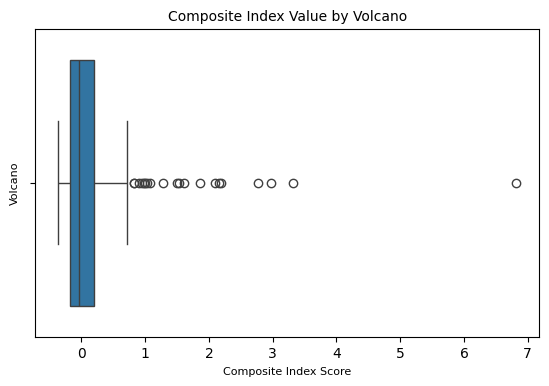

Average: 0.21522050612391913


In [ ]:
# Boxplot to show data distribution


plt.figure(figsize=(6.5, 4))

sns.boxplot(x = df_complete['composite_index'])

plt.xlabel('Composite Index Score', fontsize=8)
plt.ylabel('Volcano', fontsize=8)
plt.title('Composite Index Value by Volcano', fontsize=10)

plt.show()
print("Average:",df_complete['composite_index'].mean())